In [16]:
#Standard
import time
import numpy as np
import pandas as pd

# file manipulation
import os
import json
from ast import literal_eval

# word embedings
import gensim
from gensim import corpora, models, similarities

# Word Counter
from collections import Counter

# Visualisation
import matplotlib.pyplot as plt

# import TSNE
import sklearn

In [17]:
# Vectorization methods
def Tweet2Vec_averaging(tokens):
    tweetVec = []
    for word in tokens:
        try:
            wordVec = vectorization.wv[word]
            tweetVec.append(wordVec)
        except: continue            
    return np.mean(tweetVec, axis=0)

def Tweet2Vec_min(tokens):
    tweetVec = []
    for word in tokens:
        try:        
            wordVec = vectorization.wv[word]
            tweetVec.append(wordVec)
        except: continue
    return np.min(tweetVec, axis=0)

def Tweet2Vec_max(tokens):
    tweetVec = []
    for word in tokens:
        try:
            wordVec = vectorization.wv[word]
            tweetVec.append(wordVec)
        except: continue
    return np.max(tweetVec, axis=0)

def Tweet2Vec_minmax(tokens):
    tweetVec = []
    for word in tokens:
        try:        
            wordVec = vectorization.wv[word]
            tweetVec.append(wordVec)
        except: continue

    minVec = np.min(tweetVec, axis=0)
    maxVec = np.max(tweetVec, axis=0)
    return np.append(maxVec, minVec)

def Tweet2Vec_tfidf(tokens):
    tweetVec = []
    weightSum = 0
    for word in tokens:
        try:        
            wordVec = vectorization.wv[word]
            weight = idf[vocabulary[word]]
            
            weightSum = weightSum + weight
            tweetVec.append(wordVec*weight)
        except: continue            
    return np.mean(tweetVec, axis=0)


In [18]:
## Load word Embedings
# Load Glove (twitter trained)
DataPath = 'C:\\Users\\Vojta-Acer\\Desktop\\Diplomka\\word2vec\\glove.twitter.27B.200d.txt'
GLOVEmodel = gensim.models.KeyedVectors.load_word2vec_format(DataPath)

# Load W2V (Google News trained)
DataPath = 'C:\\Users\\Vojta-Acer\\Desktop\\Diplomka\\word2vec\\GoogleNews-vectors-negative300.bin'
W2Vmodel = gensim.models.KeyedVectors.load_word2vec_format(DataPath, binary=True)


In [19]:
## Load tweets to pandas
DataPath = 'C:\\Users\\Vojta-Acer\\Desktop\\Diplomka\\dataProcessed\\tweetsAAPL.csv'
tweetsClean = pd.read_csv(DataPath)
# convert column values to lists of words
tweetsClean['lemmas'] = tweetsClean['lemmas'].apply(literal_eval)
tweetsClean['tokens'] = tweetsClean['tokens'].apply(literal_eval)

## Index tweets
tweets = tweetsClean.copy()

# create time variables and filter spam
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format='%Y-%m-%d %H:%M:%S')
tweets['date'] = tweets['created_at'].astype(str).str[:10]
tweets['hour'] = tweets['created_at'].astype(str).str[11:13]
tweets['minute'] = tweets['created_at'].astype(str).str[14:16]
tweets['5min'] = (tweets['minute'].astype(int)//5)*5
tweets = tweets.drop_duplicates(['date', 'text'])

#Reindex
tweets.set_index(['date', 'hour', '5min' ,'minute', 'id'], inplace = True)

# learn TF IDF on tokens
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, stop_words='english', min_df = 5)
tfidf_matrix = tfidf.fit_transform(tweets['tokens'])

# get  IDF dictionary
vocabulary = tfidf.vocabulary_
idf = tfidf.idf_

In [20]:
# load example tweets
exampleTweets = pd.read_csv('tweetsExamplesSelection.csv')
#exampleTweets = pd.read_csv('tweetsExamplesSelection.csv')
#exampleTweets = pd.read_csv('tweetsExamplesFull.csv')

colorDict = {'A':'red', 'B':'blue', 'C':'green', 'D':'black', 'E':'purple', 'F':'brown', 'G':'yellow', 'H':'orange'}
colorSeries = exampleTweets['Color'].apply(lambda x: colorDict[x])
classes = exampleTweets['Topic']

In [21]:
# Select method of embedding vectorization

vectorization = GLOVEmodel
#vectorization = W2Vmodel

In [22]:
df = exampleTweets['Message'].apply(Tweet2Vec_averaging)
twitterVec = df.apply(pd.Series)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


<h2> TSNE Plot using Twitter trained Word2Vec<h2/>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 37 samples in 0.000s...
[t-SNE] Computed neighbors for 37 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 37 / 37
[t-SNE] Mean sigma: 0.240938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.589607
[t-SNE] Error after 1450 iterations: 0.400895


Text(0.5,1,'Tweet vectorization - Mean of word vector')

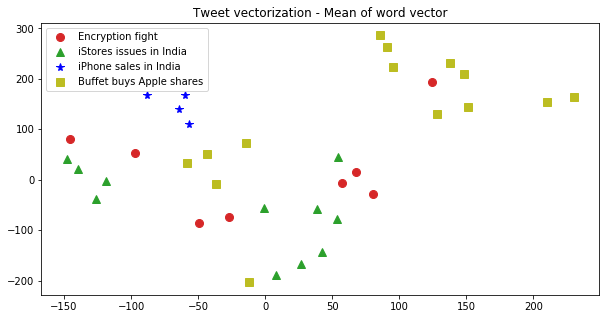

In [23]:
df = exampleTweets['Message'].apply(Tweet2Vec_averaging)
twitterVec = df.apply(pd.Series)
color_to_marker = {'red': u'o','green': u'o','yellow':u'+', 'brown': u'+'}
markerSeries = colorSeries.map(pd.Series(color_to_marker))


from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=6, n_iter=12000, random_state=7)
#tsne = TSNE(n_components=2, verbose=1, perplexity=3, n_iter=12000, random_state=7)

tsne_results = tsne.fit_transform(twitterVec.values)

x = tsne_results[:,0]
y = tsne_results[:,1] 

class_id_convertor={'Encryption fight':1, 
                    'iStores issues in India':2,
                    'iPhone sales in India  ':3,
                    'Buffet buys Apple shares':4}

inv_class_id_convertor = {v: k for k, v in class_id_convertor.items()}
class_id = classes.map(class_id_convertor)
df = pd.DataFrame({'x': x, 'y':y, 'class_name': classes, 'class_id': class_id})
groups = df.groupby('class_id')

color_to_marker = {1: 'o',2: '^',3:'*', 4: 's'}
color_to_color = {1: 'C3',2: 'C2',3:'blue', 4: 'C8'}

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.margins(0.05)
for name, group in groups:
    marker = color_to_marker[name]
    color = color_to_color[name]
    label = inv_class_id_convertor[name]
    ax.plot(group.x, group.y, marker=marker, color = color, linestyle='', ms=8, label=label)
ax.legend()

plt.title("Tweet vectorization - Mean of word vector")


<h2> TSNE Plots Combined <h2/>


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 37 samples in 0.000s...
[t-SNE] Computed neighbors for 37 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 37 / 37
[t-SNE] Mean sigma: 0.240938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.589607
[t-SNE] Error after 1450 iterations: 0.400895
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 37 samples in 0.001s...
[t-SNE] Computed neighbors for 37 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 37 / 37
[t-SNE] Mean sigma: 1.424380
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.398735


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


[t-SNE] Error after 2450 iterations: 0.394362


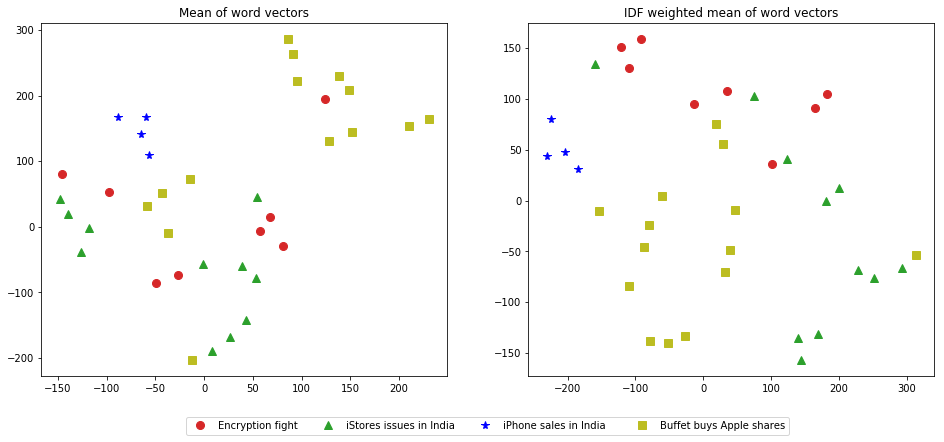

In [25]:
# FIGURE
fig, ax = plt.subplots(1,2, figsize = (16, 6.5))

# PLOT 1
df = exampleTweets['Message'].apply(Tweet2Vec_averaging)
twitterVec = df.apply(pd.Series)
color_to_marker = {'red': u'o','green': u'o','yellow':u'+', 'brown': u'+'}
markerSeries = colorSeries.map(pd.Series(color_to_marker))
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=6, n_iter=12000, random_state=7)
tsne_results = tsne.fit_transform(twitterVec.values)
x = tsne_results[:,0]
y = tsne_results[:,1] 

class_id_convertor={'Encryption fight':1, 
                    'iStores issues in India':2,
                    'iPhone sales in India  ':3,
                    'Buffet buys Apple shares':4}
inv_class_id_convertor = {v: k for k, v in class_id_convertor.items()}
class_id = classes.map(class_id_convertor)
df = pd.DataFrame({'x': x, 'y':y, 'class_name': classes, 'class_id': class_id})
groups = df.groupby('class_id')
color_to_marker = {1: 'o',2: '^',3:'*', 4: 's'}
color_to_color = {1: 'C3',2: 'C2',3:'blue', 4: 'C8'}
ax[0].margins(0.05)
for name, group in groups:
    marker = color_to_marker[name]
    color = color_to_color[name]
    label = inv_class_id_convertor[name]
    ax[0].plot(group.x, group.y, marker=marker, color = color, linestyle='', ms=8, label=label)
ax[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.1), ncol=4)
ax[0].set_title("Mean of word vectors")

# PLOT 2
df = exampleTweets['Message'].apply(Tweet2Vec_tfidf)
twitterVec = df.apply(pd.Series)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=4, n_iter=12000, random_state=7)
tsne_results = tsne.fit_transform(twitterVec.values)
x = tsne_results[:,0]
y = tsne_results[:,1] 
class_id_convertor={'Encryption fight':1, 
                    'iStores issues in India':2,
                    'iPhone sales in India  ':3,
                    'Buffet buys Apple shares':4}
inv_class_id_convertor = {v: k for k, v in class_id_convertor.items()}
class_id = classes.map(class_id_convertor)
df = pd.DataFrame({'x': x, 'y':y, 'class_name': classes, 'class_id': class_id})
groups = df.groupby('class_id')
color_to_marker = {1: 'o',2: '^',3:'*', 4: 's'}
color_to_color = {1: 'C3',2: 'C2',3:'blue', 4: 'C8'}
ax[1].margins(0.05)
for name, group in groups:
    marker = color_to_marker[name]
    color = color_to_color[name]
    label = inv_class_id_convertor[name]
    ax[1].plot(group.x, group.y, marker=marker, color = color, linestyle='', ms=8, label=label, )
ax[1].set_title("IDF weighted mean of word vectors")
fig.savefig('visualisation_glove_vectorization.png', bbox_inches="tight")